## Zero noise extrapolation with mitiq on Amazon Braket

In this notebook, we look at extrapolative approaches for mitigating errors, namely Zero-Noise Extrapolation (ZNE) and some related variants. Here, mitiq provides built in functions to (1) execute circuits with ZNE, (2) prepare the extrapolated circuits, and (3) recombine and post-process results. 

ZNE provides the backbone of many succussful quantum simulations, and has been incorporated into techniques such as PEA. 

### Installing mitiq
>[!WARNING]
>mitiq is distributed under the GPL GNU v3 license, and so is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 




In [3]:
# !pip install -U mitiq
try:
    import mitiq
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")


Package 'mitiq' is installed.



### Basics of Zero Noise Extrapolation

Given a function $f(x)$, we would like to estimate $f(0)$ using a series of varying $x > 0$. For ZNE, $x$ describes the noise parameter. Importantly, making specific assumptions about noise sources and behavior within our circuit, differing values of $x$ correspond with different circuits where we have amplified noise. The most common strategy for noise amplification is unitary gate folding, where we take a gate $U$, and map it to the logically equivalent $U U^\dagger U$. This can be the global unitary $U$ (global folding), or local unitaries composed together ($U_i$). Thus, independent noise sources within our system can be amplified by a n odd factor. However, some noise, particularly coherent noise, will remain constant. Correlated noise also can have strange behaviors. 

Regardless, using this, we can perform an extrapolation based on our knowledge of different circuits. 

Different extrapolation schemes lead to diffrernt biases, and so generally we do not consider ZNE to be an unbiased approach for all noise models.



### Setting up our problem and getting imports

In [4]:

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.emulation.local_emulator import LocalEmulator
import warnings 
warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_braket_provider")
import matplotlib.pyplot as plt 
from braket.circuits.observables import Z

import numpy as np 
np.set_printoptions(linewidth=400,precision=3,suppress=True)
from braket.emulation.local_emulator import LocalEmulator
import json
from mitiq.zne import construct_circuits
from qiskit_braket_provider import to_braket, to_qiskit
from math import pi 

with open("emerald_properties_251106.json","r") as fp:
    props = json.load(fp)

emulator = LocalEmulator.from_json(props)
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)


In [5]:

def rxx_pi4(i,j):
    """ implement an Rxx(pi/4) gate from a CNOT """
    return Circuit().h(i).cnot(i,j).h(i).rx(i,pi/8).rx(j,pi/8)

def rzz_angle(i,j, theta):
    """ implement e^(i  theta X_i X_j) """
    return Circuit().cnot(i,j).rz(j, -2 *theta).cnot(i,j)

def ising_1d(self_interaction : float, hopping : float, num_qubits : int) -> Circuit:
    circ = Circuit()
    for i in range(num_qubits):
        circ.rx(i,-2*self_interaction)
    for i in range(0,num_qubits-1,2):
        circ+= rzz_angle(i,i+1, hopping)
    for i in range(1,num_qubits-1,2):
        circ+= rzz_angle(i,i+1, hopping)
    # circ = to_braket(
    #     to_qiskit(
    #         circ, add_measurements=False), 
    #         basis_gates=["cz","r"], 
    #         optimization_level=1)
    return circ

test = ising_1d(0.2,0.05, 10)
print(test)


T  : │      0      │  1  │      2      │  3  │  4  │      5      │  6  │
      ┌───────────┐                                                     
q0 : ─┤ Rx(-0.40) ├───●───────────────────●─────────────────────────────
      └───────────┘   │                   │                             
      ┌───────────┐ ┌─┴─┐ ┌───────────┐ ┌─┴─┐                           
q1 : ─┤ Rx(-0.40) ├─┤ X ├─┤ Rz(-0.10) ├─┤ X ├───●───────────────────●───
      └───────────┘ └───┘ └───────────┘ └───┘   │                   │   
      ┌───────────┐                           ┌─┴─┐ ┌───────────┐ ┌─┴─┐ 
q2 : ─┤ Rx(-0.40) ├───●───────────────────●───┤ X ├─┤ Rz(-0.10) ├─┤ X ├─
      └───────────┘   │                   │   └───┘ └───────────┘ └───┘ 
      ┌───────────┐ ┌─┴─┐ ┌───────────┐ ┌─┴─┐                           
q3 : ─┤ Rx(-0.40) ├─┤ X ├─┤ Rz(-0.10) ├─┤ X ├───●───────────────────●───
      └───────────┘ └───┘ └───────────┘ └───┘   │                   │   
      ┌───────────┐                           ┌─┴─┐

Here we see our standard 1-d transverse field Ising model circuit, using ZZ rotations. Now we can get ideal expectation values.

In [6]:

qd_exact = LocalSimulator()
obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

circ = Circuit()
ideal_evs = []
ideal_stds = []
for steps in range(10):
    circ+= test + test
    res = qd_exact.run(circ + obs, shots = 0).result()
    ideal_evs.append(res.values)


dat = np.array(ideal_evs)
dat.shape



(10, 10)

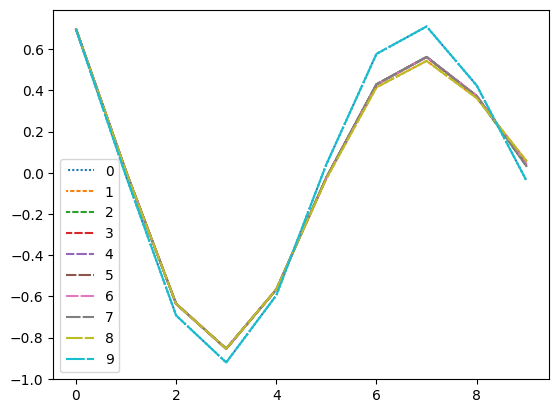

In [7]:
# plt.errorbar(range(len(ideal_evs)), ideal_evs, ideal_stds, capsize=3, marker='x',linewidth=1)
for i in range(10):
    plt.plot(range(10), dat[:,i], label = f'{i}', linestyle = (1,(i+1,1)))
    plt.legend()

In this regime we see oscillatory behavior that is pretty consistent across local sites, with the exception of the edges.  

Below, we calculate the same result using our noise model (note we are not quite using ProgramSets yet). 

In [8]:
print('Calculating noise results...')
obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

noisy_circ = Circuit()
noisy_evs = []
for step in range(10):
    noisy_circ+= test + test
    ncirc = to_braket(
        to_qiskit(
            noisy_circ, add_measurements=False), 
            basis_gates=["cz","r"], 
            optimization_level=2)
    print(f'Running step: {step}')
    res = qd.run(ncirc +  obs, shots = 10000).result()
    noisy_evs.append(res.values)
print('Done!')
noisy_evs = np.array(noisy_evs)

Calculating noise results...
Running step: 0
Running step: 1
Running step: 2
Running step: 3
Running step: 4
Running step: 5
Running step: 6
Running step: 7
Running step: 8
Running step: 9
Done!


Text(0, 0.5, 'Expectation Value')

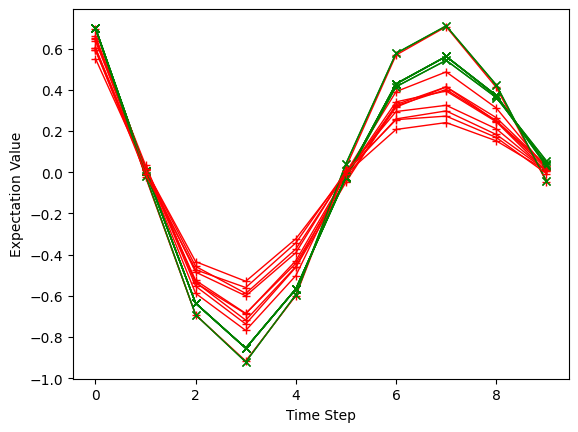

In [9]:
for i in range(10):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), noisy_evs[:,i], marker='+',c='r',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

### Running the Noise-Extrapolated Results

Finally, to compare, we will run our noisy circuits, this time using the constructed noise-amplification factors. 

In [10]:
scale_factors = [1.0, 2.0, 3.0]


obs = Circuit()
for i in range(10):
    obs.expectation(Z(i))

circ=  Circuit()
zne_evs = np.zeros((10,3,10))
for step in range(10):
    circ+= test + test
    circuits = construct_circuits(circ, scale_factors)
    temp = np.zeros((10,3))
    print(f'Running step: {step}')
    for j,item in enumerate(circuits):
        print(f'  - subcircuit {j}')
        ncirc = to_braket(
            to_qiskit(
                item, add_measurements=False), 
                basis_gates=["cz","r"], 
                optimization_level=0)

        res = qd.run(ncirc + obs, shots = 10000).result()
        zne_evs[step,j,:] = res.values
print('Done!')

Running step: 0
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 1
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 2
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 3
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 4
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 5
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 6
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 7
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 8
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 9
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Done!


### Performing Extrapolations with mitiq.zne.inference Factories


Now that we have three results, we will look at means of extrapolating these via post processing. In particular, we consider three different fits, a `LinearFactory`, an `ExponentialFactory` and a `RichardsonFactory`. 

The `LinearFactory` performs a simple least-squared fit of the data. 

The `ExpFactory` tries to fit an exponential curve to the data of the form $y(x) = a + b * \exp(-c * x)$, with $c > 0$. Notably, we can also incorporate the infinite limit, which effectively sets $a$, and then allows for a linear regression of the form $log(y(x)) = log(b) - c x$. For common expectation value problems, this is typically the trace of the observable $a = {\rm Tr}[\hat O]$. 

The `RichardsonFactory` performs Richardson extrapolation to fit $n$ data points to a degree $n-1$ polynomial, of which there is a unique solution. Thus it has some nice guarantees, namely there are existing expression for the variance and bias of the resulting estimate we can harness. 


In [11]:
from mitiq.zne import combine_results
from mitiq.zne.inference import RichardsonFactory, ExpFactory, LinearFactory

extrapolated_linear = np.zeros((10,10))
extrapolated_richard = np.zeros((10,10))
extrapolated_exp = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        extrapolated_exp[i,j] = ExpFactory.extrapolate(scale_factors, zne_evs[i,:,j].tolist(), asymptote = 0.0, eps = 0.01)
        extrapolated_richard[i,j] = combine_results(scale_factors, zne_evs[i,:,j].tolist(), RichardsonFactory.extrapolate)
        extrapolated_linear[i,j] = combine_results(scale_factors, zne_evs[i,:,j].tolist(),  LinearFactory.extrapolate)



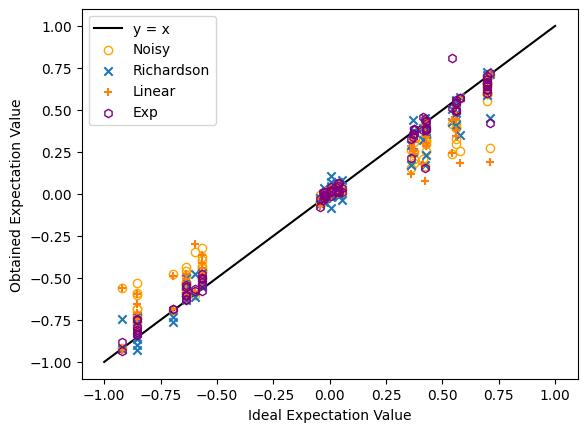

In [12]:
xs = np.linspace(-1,+1,51)
plt.plot(xs,xs,color='k',zorder=0, label="y = x")
plt.scatter(dat.flatten(), noisy_evs.flatten(), marker = 'o', facecolor=(0,0,0,0), edgecolor='orange', label="Noisy")
plt.scatter(dat.flatten(), extrapolated_richard.flatten(), label="Richardson", marker = 'x')
plt.scatter(dat.flatten(), extrapolated_linear.flatten(), label="Linear", marker = '+')
plt.scatter(dat.flatten(), extrapolated_exp.flatten(), label="Exp", marker = 'h', facecolor=(0,0,0,0), edgecolor='purple')
plt.xlabel("Ideal Expectation Value")
plt.ylabel("Obtained Expectation Value")
plt.legend()

In [13]:
for data, name in zip([extrapolated_linear, extrapolated_richard, extrapolated_exp], ["Linear ", "Richard", "Exponen"]):
    score = np.square(dat.flatten() - data.flatten())
    print(f'Average residual error [{name}]: {np.average(score):.4f}({np.std(score):.4f})')

Average residual error [Linear ]: 0.0166(0.0377)
Average residual error [Richard]: 0.0059(0.0120)
Average residual error [Exponen]: 0.0041(0.0130)


Taking a closer look at the exponential function performance, we can model it as:

Text(0, 0.5, 'Expectation Value')

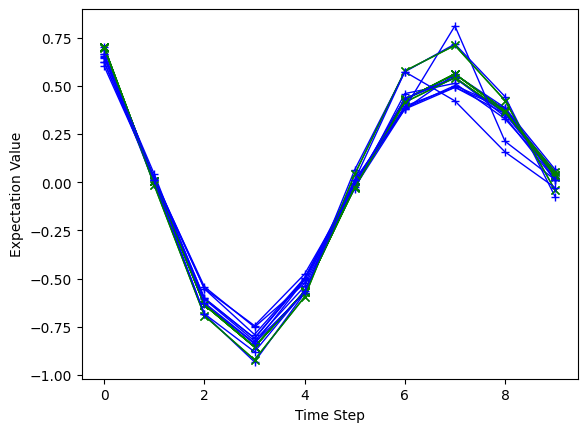

In [14]:
for i in range(10):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), extrapolated_exp[:,i], marker='+',c='b',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

### On Bias and Variance in ZNE

For ZNE, there are further factors which can impact the quality of our extrapolation, and lead to increased or modified variances as well as non-zero biases. Below we discuss the three methods covered above. 

For the exponential and linear factories, we cannot explicitly calculate the bias. However, we can estimate the resulting variance using known statistical results. In particular we can look at the variance of a linear mean regression. 

For Richardson extrapolation, previous references have provided extensive depections. 


### Layer-wise Richardson Extrapolation and Variants

For realistic systems, there can be much more complex noise models which affect noise sources. We can address this in a nubmer of ways, particularly via more complex extrapolative techniques. 

One such approach supported in mitiq is layerwise Richarson extrapolation. If we consider our original extrpaolating function $f(x)$ with a multivariate input, i.e. $f(x_0, x_1, x_2,...)$, then we can still perform many types of regression. While this is still an open research area, LRE provides an extensive way to perform this extrapolation. 

In [16]:
from mitiq.lre.multivariate_scaling import  multivariate_layer_scaling, get_scale_factor_vectors

degree = 2
fold_multiplier = 1
num_chunks = 2

test_circ =  Circuit()
for step in range(8*2):
    test_circ += test
test_circ = to_braket(
    to_qiskit(
        test_circ, add_measurements=False), 
        basis_gates=["cz","rx","rz"], 
        optimization_level=0)


lre_circuits = multivariate_layer_scaling(test_circ, degree, fold_multiplier, num_chunks = num_chunks)

print('total number of generated circuits: {}'.format(len(lre_circuits)))


total number of generated circuits: 6


Importantly we use the `num_chunks` argument to reduce the number of partitions within the circuit, and thus the overall degree of the polynomial. 

In [17]:
from mitiq.lre.inference import multivariate_richardson_coefficients
from mitiq_braket_tools import braket_measurement_executor
from mitiq import Observable, PauliString

executor = braket_measurement_executor(qd,10000, verbatim=False, batch_if_possible=False)
ideal_executor = braket_measurement_executor(LocalSimulator(), 10000, verbatim = False, batch_if_possible= False)

# nlre_circuits = [qd._noise_model.apply(c) for c in lre_circuits]
# print(lre_circuits[0])


results = [executor.evaluate(
    circuits=c, 
    observable=Observable(PauliString("IIIIZIIIII"))) for c in lre_circuits]

ideal = ideal_executor.evaluate(
    circuits=test_circ, 
    observable=Observable(PauliString("IIIIZIIIII")))

print(results)

coefficients = multivariate_richardson_coefficients(
    test_circ,
    fold_multiplier=fold_multiplier,
    degree=degree,
    num_chunks=num_chunks)
print(coefficients)

/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from Cirq to Braket.
  warn("Measurement gate removed when converting from Cirq to Braket.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from Cirq to Braket.
  warn("Measurement gate removed when converting from Cirq to Braket.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from Cirq to Braket.
  warn("Measurement gate removed when converting from Cirq to Braket.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from 

[[(0.3554+0j)], [(0.2328+0j)], [(0.274+0j)], [(0.1634+0j)], [(0.177+0j)], [(0.1712+0j)]]
[3.000000000000001, -1.5000000000000002, -1.5000000000000002, 0.375, 0.24999999999999994, 0.375]


In [18]:
from mitiq.lre.lre import combine_results


lre_result = combine_results(
    np.reshape(results,(len(results),)), circuit=test_circ, degree=degree, fold_multiplier=fold_multiplier, num_chunks = num_chunks)
print(f'Layerwise Richardson Extrapolation result: {lre_result}')
print(f"Ideal: {ideal[0]}")
print(results)
noisy = abs(results[0][0] - ideal[0])
imp_fact = noisy / abs(lre_result - ideal[0])
if imp_fact < 1:
    print("Extrapolation decreased result, might be an issue in your extrapolation or noise model.")
print(f"Improvement over noisy: {imp_fact:.1f}x")


Layerwise Richardson Extrapolation result: (0.475725+0j)
Ideal: (0.5654+0j)
[[(0.3554+0j)], [(0.2328+0j)], [(0.274+0j)], [(0.1634+0j)], [(0.177+0j)], [(0.1712+0j)]]
Improvement over noisy: 2.3x


In [ ]:
factory =  RichardsonFactory(scale_factors)
for s,e in zip(scale_factors, zne_evs[5,:,5]):
    factory.push({"scale_factor":s}, e)
factory.reduce()

factory.plot_fit()

TypeError: expected 1D vector for x

### Conclusion

In this notebook we looked at extrapolation based approaches, including standard zero-noise extrapolation as well as layerwise Richardson extrapolation. mitiq has many other options for enhancing ZNE results, which we encourage the interested use to explore. We will epxlore larger scale applications in subseqeuent notebooks. 

### References

1. https://mitiq.readthedocs.io/en/stable/guide/zne.html
2. Best practices with ZNE 
